In [22]:
import pandas as pd
import os
import numpy as np
from copy import deepcopy

In [23]:
st = pd.HDFStore(os.path.expanduser("/Users/nipunbatra/wiki-all.h5"))

In [24]:
metadata_df = pd.read_csv("/Users/nipunbatra/w/dataport-metadata.csv",index_col=0)

In [25]:
feeds = {'use':'aggregate',
        'air1':'hvac',
         'clotheswasher1':'wm',
         'dishwasher1':'dw',
         'microwave1':'mw',
         'refrigerator1':'fridge',
         'oven1':'oven',
        'car1':'ec',
         'waterheater1':'wh',
         'drye1':'dr'
        }

In [26]:
cities = ['Austin','Houston','San Diego','Boulder']

In [27]:
months=12
start='1-1-2015'
start_month=1
end = '12-31-2015'
end_month=12

In [28]:
city = 'San Diego'
city_data = metadata_df[metadata_df['city'] == city]
city_homes = city_data.index.values.astype('int')

In [29]:
home = city_homes[2]

In [30]:
data_df = st['/%d' %home][start:end]
data_df_resampled = data_df.resample("1M", how="sum")
df_res_kwh = data_df_resampled.div(1000)
df_res_kwh.index = df_res_kwh.index.month

In [31]:
data_df.columns

Index([u'use', u'air1', u'clotheswasher1', u'dishwasher1', u'disposal1',
       u'dryg1', u'furnace1', u'kitchenapp1', u'kitchenapp2', u'microwave1',
       u'refrigerator1'],
      dtype='object')

In [32]:
out_overall = {}
to_ignore = []
for city in cities[:]:
    print city
    city_data = metadata_df[metadata_df['city'] == city]
    city_homes = city_data.index.values.astype('int')
    out = {}
    for home in city_homes[:]:
        if home in to_ignore:
            continue
        try:
            data_df = st['/%d' %home][start:end]
            data_df_resampled = data_df.resample("1M", how="sum")
            df_res_kwh = data_df_resampled.div(1000)
            df_res_kwh.index = df_res_kwh.index.month
            temp = {}
            for feed_name, feed_value in feeds.iteritems():
                temp[feed_value] = []
                for month in range(start_month, end_month+1):
                
                
                    try:
                        temp[feed_value].append(df_res_kwh.loc[month, feed_name])
                    except:
                        temp[feed_value].append(np.NAN)
            out[home] = np.hstack(temp.values())
                        
            
            
            
        except Exception, e:
            pass
    appliances = temp.keys()
    col_headers = []
    for appliance in appliances:
        for month in range(start_month, end_month+1):
            col_headers.append(appliance+"_"+str(month))
    df = pd.DataFrame(out).T
    df.columns = col_headers
    
    # Read metadata
    mdf = pd.read_csv("../data/input/%s_md.csv" %city.replace(" ",""), index_col=0)
    for column in mdf.columns:
        df[column] = mdf[column]
    
    city = city.replace(" ","")
    out_overall[city] =df
    
    # Set metadata available flag
    df['md_available'] = (df['area']>0).astype('int')
    
    tdf = df[['aggregate_'+str(month) for month in range(start_month, end_month+1)]].dropna().copy()
    full_agg = {}
    min_max_ratio = {}
    difference_min_max_ratio = {}
    variance = {}
    kurt = {}
    skew= {}
    p_25 = {}
    p_75 = {}
    p_50 = {}
   
    for home in df.index:
        if home in tdf.index:
            full_agg[home] = 1
            difference_min_max_ratio[home] = (tdf.ix[home].max()-tdf.ix[home].min())/tdf.ix[home].max()
            min_max_ratio[home] = tdf.ix[home].min()/tdf.ix[home].max()
            variance[home] = tdf.ix[home].var()
            p_25[home] =np.percentile(tdf.ix[home], 25)
            p_50[home] =np.percentile(tdf.ix[home], 50)
            p_75[home] = np.percentile(tdf.ix[home], 75)
            kurt[home] = tdf.ix[home].kurtosis()
            skew[home] = tdf.ix[home].skew()
            
        else:
            full_agg[home] = 0
            min_max_ratio[home] = np.NaN
            difference_min_max_ratio[home] = np.NaN
            p_25[home] = np.NaN
            p_50[home] = np.NaN
            p_75[home] = np.NaN
            skew[home] = np.NaN
            kurt[home] = np.NaN
            variance[home] = np.NaN
            
            
    df['full_agg_available'] = pd.Series(full_agg)
    df['ratio_min_max'] = pd.Series(min_max_ratio)
    df['difference_ratio_min_max'] = pd.Series(min_max_ratio)
    df['variance'] = pd.Series(variance)
    df['skew'] = pd.Series(skew)
    df['kurtosis'] = pd.Series(kurt)
    df['p_25'] = pd.Series(p_25)
    df['p_50'] = pd.Series(p_50)
    df['p_75'] = pd.Series(p_75)

Austin
Houston
San Diego
Boulder


In [33]:
import pickle

In [34]:
out_overall.keys()

['Boulder', 'Houston', 'Austin', 'SanDiego']

In [36]:
pickle.dump(out_overall, open('../data/input/all_regions.pkl','w'))

In [46]:
import sqlite3
s = sqlite3()

In [45]:
out_overall['Boulder']['wh_2'].dropna()

6083    132.092041
6148     74.410583
Name: wh_2, dtype: float64

In [286]:
features

{'md_agg': ['aggregate_1',
  'aggregate_2',
  'aggregate_3',
  'aggregate_4',
  'aggregate_5',
  'aggregate_6',
  'aggregate_7',
  'aggregate_8',
  'aggregate_9',
  'aggregate_10',
  'aggregate_11',
  'aggregate_12',
  'ratio_min_max',
  'difference_ratio_min_max',
  'p_25',
  'area',
  'house_num_rooms']}

In [269]:
distances = {}
pred = {}
for home in test_df.index:
    pred[home] = {}
    for appliance in ["hvac"]:
        pred[home][appliance] = {}
        for month in [10]:
            if test_df.ix[home][appliance+"_"+str(month)] >0:
                candidate_neighbours = train_df[appliance+"_"+str(month)].dropna().index

                # If both full md and full aggregate available in test home
                if (test_df.ix[home]['full_agg_available']==1) and (test_df.ix[home]['md_available']==1):
                    
                    subset = candidate_neighbours[(train_df.ix[candidate_neighbours]['full_agg_available']==1)&(train_df.ix[candidate_neighbours]['md_available']==1)]
                    num_features = len(features['md_agg'])
                    
                    # Normalize
                    
                    # Compute distance
                    distances = test_df.ix[home][features['md_agg']] - train_df.ix[subset][features['md_agg']] 
                    sum_distances = distances.sum(axis=1)
                    
                    # Compute effective distanc
                    effective_distance = sum_distances.div(num_features*num_features)
            else:
                pred[home][appliance][month] = np.NaN
                continue

In [263]:
sum_distances.sort()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


In [268]:
sum_distances

1731    24996.239147
2606    23386.664307
5938    28444.103563
7062    25841.485125
8061    24272.045945
8342    29354.794281
9775    24871.113339
dtype: float64

In [261]:
train_df.ix[2606]['hvac_10'], test_df.ix[home]['hvac_10']

(233.70863342285156, nan)

In [271]:
pred

{22: {'hvac': {10: nan}},
 26: {'hvac': {}},
 48: {'hvac': {10: nan}},
 59: {'hvac': {}},
 68: {'hvac': {10: nan}},
 77: {'hvac': {}},
 86: {'hvac': {}},
 93: {'hvac': {}},
 94: {'hvac': {}},
 101: {'hvac': {}},
 114: {'hvac': {}},
 115: {'hvac': {}},
 121: {'hvac': {}},
 130: {'hvac': {}},
 135: {'hvac': {10: nan}},
 160: {'hvac': {}},
 171: {'hvac': {10: nan}},
 187: {'hvac': {}},
 222: {'hvac': {}},
 243: {'hvac': {10: nan}}}

In [114]:
from collections import Counter
count_city = {}
for city in cities:
    count_city[city] = {}
    df = out_overall[city]
    for column in df.columns:
        count_city[city][column] = len(df[column].dropna())

In [118]:
%matplotlib inline

In [121]:
import seaborn as sns

In [135]:
out_overall['San Diego']['aggregate_1']

54             NaN
203     205.483978
527            NaN
1450    603.462646
1524    257.905334
1731    362.801117
2031           NaN
2354    347.915466
2606    495.969940
3687    455.923126
3864    176.973251
3938    176.716019
4083           NaN
4095           NaN
4329           NaN
4495    165.499924
4761           NaN
4934    189.487259
5009           NaN
5909           NaN
5938    173.725433
6268           NaN
6377    248.415497
6429           NaN
6497           NaN
6547    217.583496
6689           NaN
7062    405.654846
7114    259.922913
7409           NaN
7639           NaN
8061    329.014252
8342    170.240799
8574    233.745789
8733    535.651978
8886           NaN
9213    186.724442
9370           NaN
9585    231.148972
9612    244.954941
9775    397.622803
9836    222.104813
Name: aggregate_1, dtype: float64

In [183]:
out_overall['San Diego']

,hvac_1,hvac_2,hvac_3,hvac_4,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,...,dw_9,dw_10,dw_11,dw_12,house_num_rooms,area,num_occupants,md_available,full_agg_available,ratio_min_max
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
203,0.002000,0.002700,29.053850,19.651184,15.861900,68.252647,145.872055,173.272644,203.351685,72.101601,...,0.526283,0.000800,0.001083,0.002117,NaN,NaN,NaN,0,1,0.647142
527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1450,1.563983,49.754932,224.037476,105.825180,54.593281,266.363251,365.305908,497.618652,548.815247,326.567413,...,17.199583,23.286934,23.466633,27.078949,NaN,NaN,NaN,0,1,0.585763
1524,0.025400,0.027333,16.035267,4.751067,14.896517,185.289536,218.260483,325.225800,331.544067,159.814423,...,7.216333,4.558683,6.161016,6.294283,NaN,NaN,NaN,0,1,0.676419
1731,0.197017,0.000000,21.463934,12.613634,7.330667,40.226986,221.842163,286.762146,295.495148,175.822769,...,5.013783,6.311767,6.450483,6.680017,4,1555,2,1,1,0.639254
2031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2354,0.000517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2606,4.041283,48.951168,114.115364,32.597801,30.465033,118.778206,213.009796,302.353729,358.428986,233.708633,...,1.700733,2.213333,1.984700,1.563583,4,1390,2,1,1,0.559614
3687,0.000000,0.000000,29.437967,0.000000,0.000000,69.320015,183.210800,273.997559,13.414872,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [161]:
(tdf.max(axis=1)-tdf.min(axis=1))/tdf.max(axis=1)

232     0.491821
516     0.759352
547     0.604185
1350    0.457168
1766    0.390348
1879    0.552631
2931    0.401550
3104    0.223834
4147    0.468999
4499    0.344566
4601    0.576244
4703    0.575440
4920    0.400177
4974    0.620280
5187    0.230828
5400    0.460327
5904    0.339099
6148    0.410129
6264    0.335020
6888    0.494369
7001    0.628008
8273    0.492781
8368    0.509551
8395    0.720457
8555    0.420339
8622    0.505032
8862    0.736484
9085    0.374562
9142    0.584396
9156    0.423792
9818    0.593784
9958    0.475702
dtype: float64

In [14]:
to_ignore = [5400, 6800, 7208,8555,9142, 9958]

In [20]:
boulder_homes

array([4974, 7213, 6282, 3659, 9229, 2144,  698, 1350, 1766, 2523, 2903,
       3734, 4499, 4703, 4830, 5187, 6083, 6148, 6174, 6956, 7001, 7208,
       8368, 9341, 9818,  879, 2196, 5648, 5954, 8676, 3353,  232,  516,
        547, 1879, 2824, 2931, 3104, 4601, 6264, 6800, 6888, 7818, 8273,
       8622, 8729, 8862, 9085, 9142, 9156, 9958, 5904, 8395, 4920, 5652,
       4147, 5400, 8555])

In [23]:
home = boulder_homes[0]
data_df = st['/%d' %home][start:end].resample("1M",how="sum")

In [24]:
data_df

,use,air1,dishwasher1,drye1,furnace1,kitchenapp1,oven1,refrigerator1
2015-01-31 00:00:00-06:00,496061.56250,15170.500000,4140.716797,45674.351562,97686.531250,16178.366211,20175.433594,29614.033203
2015-02-28 00:00:00-06:00,414289.78125,13569.822266,4966.766602,34836.398438,78858.820312,14248.870117,15944.643555,28821.613281
2015-03-31 00:00:00-05:00,459380.87500,14520.716797,6037.116699,49289.101562,51648.148438,19235.183594,26505.816406,33367.667969
2015-04-30 00:00:00-05:00,456413.37500,13847.383789,5545.416504,58604.550781,35382.500000,16483.849609,23958.000000,31784.732422
2015-05-31 00:00:00-05:00,403121.06250,14399.583008,4984.100098,40290.316406,27349.433594,16845.849609,15058.366211,31902.750000
2015-06-30 00:00:00-05:00,687398.56250,219236.234375,6170.083496,26920.232422,60051.417969,13600.000000,16842.783203,37649.300781
2015-07-31 00:00:00-05:00,1011716.18750,491135.062500,6048.799805,40355.601562,130682.070312,12703.950195,7202.383301,37947.933594
2015-08-31 00:00:00-05:00,1008712.25000,460257.125000,4148.533203,55531.132812,116924.164062,13758.950195,8681.966797,38172.714844
2015-09-30 00:00:00-05:00,657826.31250,220316.265625,5011.000000,26502.400391,58044.015625,17139.982422,9230.933594,35374.382812
2015-10-31 00:00:00-05:00,384168.96875,13850.299805,3156.383301,43864.433594,16535.966797,17369.066406,17492.650391,32786.632812


In [15]:
out = {}
for home in boulder_homes[:]:
    if home in to_ignore:
        continue
    try:
        data_df = st['/%d' %home][start:end]
        data_df_resampled = data_df.resample("1M", how="sum")
        df_res_kwh = data_df_resampled.div(1000)
        fridge = np.array([np.NaN]*months)
        hvac = np.array([np.NaN]*months)
        aggregate = np.array([np.NaN]*months)

        if "refrigerator1" in df_res_kwh.columns:
            fridge = df_res_kwh['refrigerator1'].squeeze().values
        if 'air1' in df_res_kwh.columns:
            hvac = df_res_kwh['air1'].squeeze().values
        
    
        aggregate = df_res_kwh["use"].values

        out[home] = np.hstack([aggregate, hvac, fridge])
    except Exception, e:
        print e

'No object named /7213 in the file'
'No object named /6282 in the file'
'No object named /3659 in the file'
'No object named /9229 in the file'
'use'
'numpy.float32' object has no attribute 'values'
'No object named /879 in the file'
'No object named /2196 in the file'
'No object named /5648 in the file'
'No object named /5954 in the file'
'No object named /8676 in the file'
'use'


In [19]:
{x:len(out[x]) for x in out.keys()}

{232: 36,
 516: 36,
 547: 36,
 698: 18,
 1350: 36,
 1766: 36,
 1879: 36,
 2144: 0,
 2523: 18,
 2903: 15,
 2931: 36,
 3104: 36,
 3353: 20,
 3734: 6,
 4147: 36,
 4499: 36,
 4601: 36,
 4703: 36,
 4830: 36,
 4920: 36,
 4974: 36,
 5187: 36,
 5652: 0,
 5904: 36,
 6083: 28,
 6148: 36,
 6264: 36,
 6888: 36,
 7001: 36,
 7818: 33,
 8273: 36,
 8368: 36,
 8395: 36,
 8622: 36,
 8729: 12,
 8862: 36,
 9085: 36,
 9156: 36,
 9341: 21,
 9818: 36}

In [10]:
df = pd.DataFrame(out).T
df.columns=np.hstack([['aggregate_%d' %month for month in range(7,11)],
                          ['hvac_%d' %month for month in range(7,11)],
                          ['fridge_%d' %month for month in range(7,11)]
                          ])

ValueError: Length mismatch: Expected axis has 0 elements, new values have 12 elements

In [174]:
%matplotlib inline

In [175]:
df.to_csv("../data/input/unscaled_boulder_df.csv")

In [127]:
df["area"]=pd.Series({232: 2228.0,
 516: 2379.0,
 547: 2920.0,
 698: 2370.0,
 879: None,
 1350: 2332.0,
 1766: 2564.0,
 1879: 4123.0,
 2144: 1539.0,
 2196: None,
 2523: 4306.0,
 2824: 832.0,
 2903: 3049.0,
 2931: 1143.0,
 3104: 1539.0,
 3353: 2207.0,
 3659: 2300.0,
 3734: 4673.0,
 4147: None,
 4499: 2438.0,
 4601: None,
 4703: 1985.0,
 4830: 3971.0,
 4920: 3311.0,
 4974: 2393.0,
 5187: 3839.0,
 5400: None,
 5648: 928.0,
 5652: 2166.0,
 5904: 2352.0,
 5954: 1662.0,
 6083: 1480.0,
 6148: 2722.0,
 6174: 2124.0,
 6264: 1030.0,
 6282: 1216.0,
 6800: 3199.0,
 6888: 3409.0,
 6956: 832.0,
 7001: 2047.0,
 7208: 1176.0,
 7213: 1400.0,
 7818: 928.0,
 8273: 6147.0,
 8368: 2055.0,
 8395: 1559.0,
 8555: None,
 8622: 1032.0,
 8676: 2353.0,
 8729: 2360.0,
 8862: 928.0,
 9085: 1763.0,
 9142: 2277.0,
 9156: 1589.0,
 9229: 2424.0,
 9341: 2958.0,
 9818: 2157.0,
 9958: 1176.0})

In [128]:
def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

    #Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(start_month, end_month)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(start_month, end_month)]].min().min()
df[["aggregate_%d" % i for i in range(start_month, end_month)]] = scale_0_1(df[["aggregate_%d" % i for i in range(start_month, end_month)]],
                                                                min_aggregate, max_aggregate)

df["area"] = scale_0_1(df["area"])

df = df[df.index!=2931]
df = df[df.index!=516]

In [129]:
df.to_csv("../data/input/boulder_df.csv")

In [130]:
all_homes = {}

#all_homes['hvac'] = df[['hvac_%d' %month for month in range(start_month, end_month)]].dropna().index
all_homes['fridge'] = df[['fridge_%d' %month for month in range(start_month, end_month)]].dropna().index.tolist()

for fridge_remove in [4147]:
    all_homes['fridge'].remove(fridge_remove)

all_homes["hvac"] = df[['hvac_%d' %month for month in range(7, 9)]][df[['hvac_%d' %month for month in range(7, 9)]]>40].dropna().index.tolist()

In [131]:
import json
json.dump(all_homes, open('../data/input/boulder_homes.json','w'))

In [164]:
K_min, K_max = 1,6
F_min, F_max=1,8

#from all_functions import *
#from features import *

import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import LeaveOneOut

NUM_NEIGHBOUR_MAX = 6
F_MAX = 4

import json

feature_map = {'Monthly':['aggregate_%d' %month for month in range(start_month, end_month)],
              'Static':['area'],
              'Monthly+Static':np.hstack([['aggregate_%d' %month for month in range(start_month, end_month)],
                                        'area']).flatten().tolist()}



from sklearn.cross_validation import LeaveOneOut
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from collections import OrderedDict

def _find_accuracy(home, appliance, feature="Monthly"):
    if appliance =="hvac":
        start, stop=7, 10
    else:
        start, stop=7, 10

    np.random.seed(42)
    appliance_df = df.ix[all_homes[appliance]]
    
    #ADDING NEW
    appliance_df = appliance_df.ix[appliance_df[feature_map[feature]].dropna().index]
    
    
    test_homes = [home]
    train_homes = appliance_df[~appliance_df.index.isin([home])].index
    all_home_appliance = deepcopy(all_homes)
    all_home_appliance[appliance] = train_homes

    # Cross validation on inner loop to find best feature, K
    train_size = len(train_homes)
    l = LeaveOneOut(train_size)
    out = OrderedDict()
    for cv_train, cv_test in l:

        cv_train_home=appliance_df.ix[train_homes[cv_train]]
        cv_test_home = appliance_df.ix[train_homes[cv_test]]
        test_home_name = cv_test_home.index.values[0]
        #print cv_test_home
        out[test_home_name]={}


        # Summing up energy across start to stop to get Y to learn optimum feature on
        Y = cv_train_home[['%s_%d' %(appliance, i) for i in range(start, stop)]].sum(axis=1).values
        forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
        forest.fit(cv_train_home[feature_map[feature]], Y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Now varying K and top-N features

        for K in range(K_min, K_max):
            out[test_home_name][K]={}
            for top_n in range(F_min,F_max):
                out[test_home_name][K][top_n]=[]
                top_n_features = cv_train_home[feature_map[feature]].columns[indices][:top_n]

                # Now fitting KNN on this
                for month in range(start, stop):
                    clf = KNeighborsRegressor(n_neighbors=K)
                    clf.fit(cv_train_home[top_n_features], cv_train_home['%s_%d' %(appliance, month)])
                    out[test_home_name][K][top_n].append(clf.predict(cv_test_home[top_n_features]))

        # Now, finding the (K, top_n) combination that gave us best accuracy on CV test homes
    accur = {}

    for K in range(K_min, K_max):
        accur[K] = {}
        for top_n in range(F_min, F_max):
            temp = {}
            for h in out.iterkeys():
                pred = pd.DataFrame(out[h][K][top_n]).T
                #all_but_h = [x for x in out.keys() if x!=h]
                pred.index = [h]
                pred.columns = [['%s_%d' %(appliance, i) for i in range(start, stop)]]
                gt = appliance_df.ix[h][['%s_%d' %(appliance, i) for i in range(start, stop)]]
                error = (pred-gt).abs().div(gt).mul(100)
                mean_error = error.mean().mean()
                a = 100-mean_error
                if a<0:
                    a=0
                temp[h]=a
            ac = pd.Series(temp).mean()

            accur[K][top_n] = ac

    accur_df = pd.DataFrame(accur)
    accur_max = accur_df.max().max()
    max_ac_df = accur_df[accur_df==accur_max]
    F_best = cv_train_home[feature_map[feature]].columns[indices][:max_ac_df.mean(axis=1).dropna().index.values[0]].tolist()
    K_best = max_ac_df.mean().dropna().index.values[0]

    # Now predicting for test home
    train_overall = appliance_df.ix[appliance_df[~appliance_df.index.isin([home])].index]
    test_overall = appliance_df[appliance_df.index.isin([home])]
    pred_test = {}
    gt_test = {}
    for month in range(start, stop):
        clf = KNeighborsRegressor(n_neighbors=K_best)
        clf.fit(train_overall[F_best], train_overall['%s_%d' %(appliance, month)])
        pred_test[month] = clf.predict(test_overall[F_best])
        gt_test[month] = test_overall['%s_%d' %(appliance, month)]

    #print {'f':F_best, 'k':K_best,'accuracy':accur_max}
    #json.dump({'f':F_best, 'k':K_best,'accuracy':accur_max},open("../main-out-new/%s_%s_%d.json" %(appliance,feature, home),"w") )

    pred_df = pd.DataFrame(pred_test)
    pred_df.index = [home]
    gt_df = pd.DataFrame(gt_test)
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    accuracy_test = 100-error
    accuracy_test[accuracy_test<0]=0

    return pred_df, gt_df, accuracy_test.squeeze()

In [165]:
acc = {}
feature="Monthly"

In [166]:
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exeption, e:
                print e

hvac
232 74.1041796871
698 0.0
1879 11.9813417205
2144 31.6594543284
2523 0.0
2903 69.7342145275
3734 69.0448471582
4147 44.4514488081
4920 55.4190421478
4974 65.7657548528
5652 29.5782222032
5904 48.5928467602
7001 82.7987792367
8273 76.8208470004
8368 62.7688638136
8395 24.2746344098
9156 55.1597625137
9341 94.1019623408
9818 74.1411281938


In [171]:
pd.DataFrame(acc['hvac']).T.mean()

7    58.841806
8    58.680974
9    35.697852
dtype: float64

In [136]:
mean_across_months = {}
for appliance in acc.keys():
    if appliance =="hvac":
        mean_across_months[appliance] = pd.Series(acc[appliance])
    else:
        mean_across_months[appliance] = pd.DataFrame(acc[appliance])
    

#mean_across_months['fridge'].loc[10, 2144] = np.NaN
mean_across_months['fridge'].loc[7, 7818] = np.NaN

for appliance in mean_across_months.keys():
    mean_across_months[appliance] = mean_across_months[appliance].mean()

In [137]:
pd.DataFrame(mean_across_months).mean()

fridge    59.652438
hvac      55.285982
dtype: float64

In [88]:
pd.DataFrame(acc['fridge']).mean().mean()

59.42784357914097

In [58]:
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exeption, e:
                print e

hvac
232 51.8880534482
698 6.23831593653
1879 91.4494131347
2144 61.2847716185
2523 0.0
2903 87.7119049134
3734 70.8877995621
4147 41.5901136905
4920 80.3589791808
4974 78.1638690026
5652 35.1300152188
5904 70.4550611529
7001 55.584275075
8273 72.0190076499
8368 88.8487537827
8395 29.1328645241
9156 85.6823433101
9341 28.7706328697
9818 96.2430717916


In [61]:
pd.DataFrame(acc['hvac']).mean().mean()

59.549433992735885

In [91]:
pd.DataFrame(acc['fridge']).T

,7,8,9,10
698,94.149059,82.559953,88.429632,82.775495
1350,66.755906,54.950142,64.735635,85.783378
1879,67.454866,62.224006,65.381370,59.757326
2144,81.029731,77.122650,72.318482,14.958027
2523,97.258288,95.423534,92.703186,87.328469
2903,81.305993,84.077549,88.579349,83.476137
3104,88.948494,82.847349,92.561923,90.144014
3353,86.787986,83.138124,82.854396,82.493751
3734,94.243104,89.492515,93.280111,80.802746
4601,9.453191,0.000000,21.244454,52.761055


In [89]:
df[['fridge_%d' %month for month in range(start_month, end_month)]].dropna()

,fridge_7,fridge_8,fridge_9,fridge_10
516,15.534883,17.164131,34.869167,31.562416
698,64.191200,57.133865,54.823750,50.255817
1350,66.516800,77.818665,59.687233,57.797764
1879,85.370651,84.205200,73.029518,73.792221
2144,59.276733,56.902199,55.143650,19.762566
2523,78.406364,75.180016,69.187485,63.164581
2903,78.262619,72.784721,63.093933,67.747849
3104,54.740536,53.272900,48.935200,45.424648
3353,106.416916,107.191032,98.034454,95.368233
3734,64.874115,59.599384,55.120102,49.965183


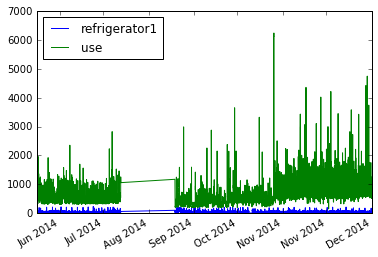

In [71]:
st['/516']['2014'][['refrigerator1', 'use']].plot()

516 has data collection issues! remove from all appliances.

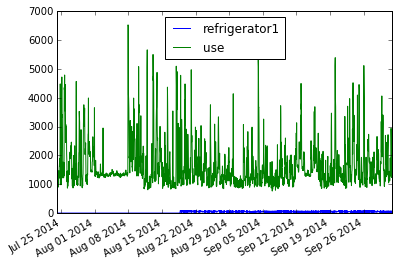

In [77]:
st['/4147']['7-1-2014':'10-1-2014'][['refrigerator1', 'use']].plot()

In [ ]:
4147 has some missing data. remove from fridge

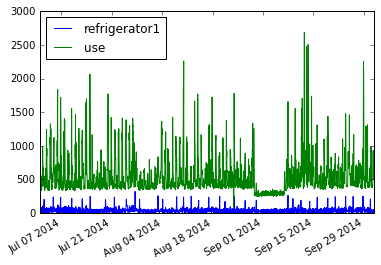

In [78]:
st['/4703']['7-1-2014':'10-1-2014'][['refrigerator1', 'use']].plot()

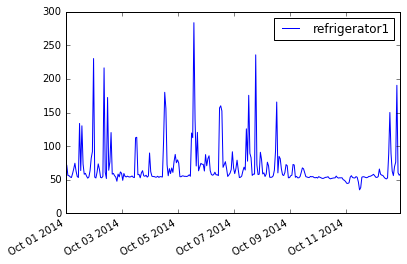

In [102]:
st['/2144']['10-1-2014':'11-1-2014'][['refrigerator1']].plot()

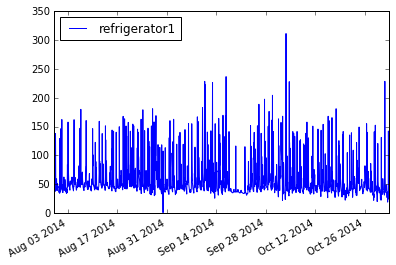

In [107]:
st['/7818']['7-1-2014':'11-1-2014'][['refrigerator1']].plot()

In [ ]:
2144 ends early. Put np.NaN in fridge, 2144, 10
7818 starts late, Put np.NaN in fridge, 7818, 7

In [139]:
acc_2 = {}
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc_2:
        continue
    else:
        print appliance
        acc_2[appliance] = {}
        feature="Monthly+Static"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc_2[appliance][home]=out_df
                print home, acc_2[appliance][home].mean()
            except Exception, e:
                print e

hvac
232 85.5318120427
698 0.0
1879 69.7006293564
2144 57.8747660792
2523 0.0
2903 71.5896189227
3734 98.5087953823
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
4920 34.7913881549
4974 77.5048849213
5652 27.7081317313
5904 53.8384384148
7001 56.6933868386
8273 99.1291562447
8368 96.7165774147
8395 38.4708448082
9156 60.7288410349
9341 39.5936536109
9818 97.4500525303


In [143]:
pd.DataFrame(acc_2).mean()

hvac    59.212832
dtype: float64

In [144]:
df

,aggregate_7,aggregate_8,aggregate_9,aggregate_10,hvac_7,hvac_8,hvac_9,hvac_10,fridge_7,fridge_8,fridge_9,fridge_10,area
232,0.484139,0.495422,0.371931,694.200195,338.407410,334.595459,63.463852,15.140766,NaN,NaN,NaN,NaN,0.262653
547,0.550198,0.507525,0.608891,1517.996460,34.373417,18.198683,8.908184,0.437633,NaN,NaN,NaN,NaN,0.392850
698,0.529120,0.438695,0.411129,851.687927,168.810211,61.519470,2.300000,0.118233,64.191200,57.133865,54.823750,50.255817,0.289370
1350,0.180680,0.230210,0.124130,408.752808,16.532484,65.803162,0.599133,3.867483,66.516800,77.818665,59.687233,57.797764,0.282220
1766,0.225406,0.230578,0.201784,452.142517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325870
1879,0.504281,0.443358,0.301665,754.656860,294.709778,174.642090,0.552867,0.146300,85.370651,84.205200,73.029518,73.792221,0.619191
2144,0.579852,0.525803,0.410075,175.338425,598.515564,490.403564,303.959320,0.002017,59.276733,56.902199,55.143650,19.762566,0.133020
2523,0.754973,0.595664,0.519899,1000.518616,135.648438,70.280182,15.237200,8.047383,78.406364,75.180016,69.187485,63.164581,0.653622
2903,0.345137,0.277248,0.264845,503.319336,120.667900,73.585297,54.004265,15.935367,78.262619,72.784721,63.093933,67.747849,0.417121
3104,0.110492,0.109131,0.116767,248.196533,11.799868,1.095700,0.020450,0.008650,54.740536,53.272900,48.935200,45.424648,0.133020


In [150]:
import matplotlib.pyplot as plt

In [155]:
import sys
sys.path.append("../code/")

In [156]:
from common_functions import tableau20blind, format_axes

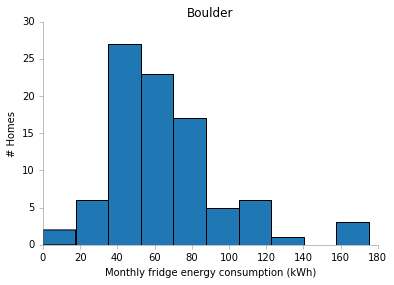

In [163]:
pd.Series(df[['fridge_7','fridge_8','fridge_9']].dropna().values.flatten()).hist(color=tableau20blind[0])
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")
plt.title("Boulder")
plt.ylabel("# Homes")
plt.savefig("../results/boulder_fridge_hist.png")

In [318]:
sum([len(out_overall[x]) for x in out_overall])

697